# Load Dataset

In [1]:
!pip install gdown
import os
import gdown
import zipfile

if not os.path.isdir("Mushrooms"):
  url = 'https://drive.google.com/uc?id=1BUD8rvVAwon48pnMmUJAKIoZE8AqTRhy'
  output = 'Mushrooms.zip'
  gdown.download(url, output, quiet=False)
  with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(".")

In [2]:
!pip install jupyter_contrib_nbextensions
!pip install fastai
!pip install fastai --upgrade
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

Requirement already up-to-date: fastai in /home/alex/anaconda3/lib/python3.8/site-packages (2.0.13)


ERROR: Could not find a version that satisfies the requirement opencv-python==3.4.2.16 (from versions: 3.4.8.29, 3.4.9.31, 3.4.9.33, 3.4.10.35, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 4.1.2.30, 4.2.0.32, 4.2.0.34, 4.3.0.36, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44)
ERROR: No matching distribution found for opencv-python==3.4.2.16
ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.16 (from versions: 3.4.8.29, 3.4.9.31, 3.4.9.33, 3.4.10.35, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 4.1.2.30, 4.2.0.32, 4.2.0.34, 4.3.0.36, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.16


In [3]:
import numpy as np 
import pandas as pd 
import os


from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.metrics import error_rate

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)

In [5]:
batch_size=32
classes = ['Boletus','Entoloma','Russula','Suillus','Lactarius','Amanita','Agaricus','Hygrocybe','Cortinarius']

In [6]:
path = Path("Mushrooms")
print(path)

Mushrooms


In [7]:
# Read dataset and split on train and validation sets. Validation = 20% of dataset.
dls_tmp = ImageDataLoaders.from_folder(path,
                                   valid_pct=0.4,
                                   item_tfms=Resize(224),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats),
                                   num_workers=4,
                                   bs=batch_size,
                                   val_bs=batch_size,
                                  )

In [8]:
import random

def label_func(x): return x.parent.name
def dataloader_from_items(items, valid_pct):
  return ImageDataLoaders.from_path_func(
    path, 
    items, 
    label_func,
    item_tfms=Resize(224),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    num_workers=4,
    valid_pct=valid_pct,
    bs=batch_size)

valid_items = dls_tmp.valid.items
random.shuffle(valid_items)
# Split validation set on two equal parts: test and validation.
# Resulting sizes (approximately) train: 64%, validation: 16%, test: 20% of the dataset.
# Note: test should have batches of equal sizes (64 by default), otherwise predictions will crush.
test_dls = dataloader_from_items(valid_items[:len(valid_items)//batch_size//2*batch_size], valid_pct=0.0)
dls = dataloader_from_items(valid_items[len(valid_items)//batch_size//2*batch_size:]+dls_tmp.train.items, valid_pct=0.2)
print("Train size: {}, Validation size: {}, Test size: {}".format(
    len(dls.train.items), len(dls.valid.items), len(test_dls.items)))

Train size: 4322, Validation size: 1080, Test size: 1312


Train/Validation


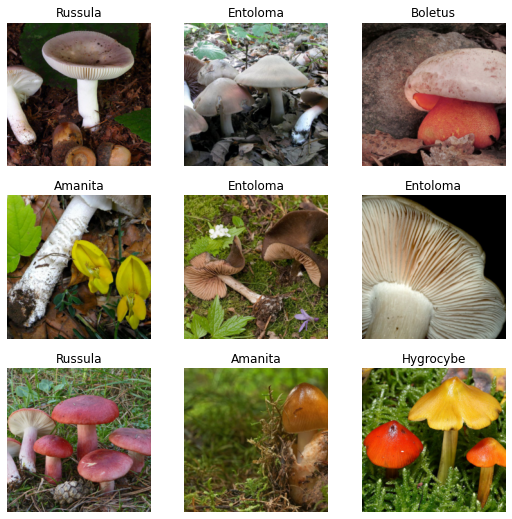

In [9]:
print("Train/Validation")
dls.show_batch()

Test


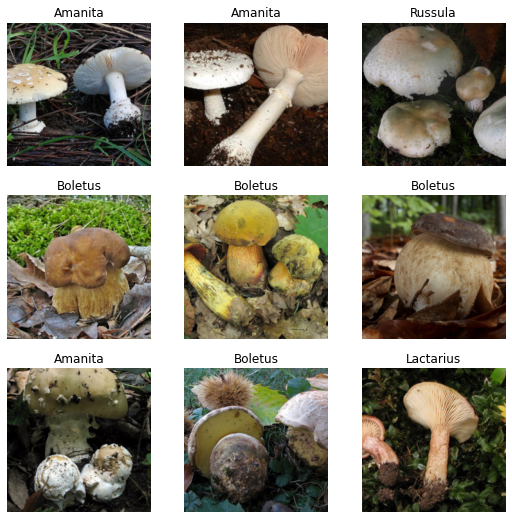

In [10]:
print("Test")
test_dls.show_batch()

# Helper functions

In [11]:
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def tensor_to_numpy_image(img):
  # this converts it from GPU to CPU and selects first image
  img = img.cpu().numpy()
  #convert image back to Height,Width,Channels
  img = np.transpose(img, (1,2,0))
  img = img.astype(np.uint8)
  #show the image
  return img

# Train model

In [12]:
from PIL import ImageFile
import fastai.vision.models as models
significant_reduce = 1e-2
max_iterations = 5

ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(learner):
  prev_loss = 1e9
  iteration = 0
  # Fine tune while validation loss reduces significantly
  while iteration < max_iterations and (learner.recorder.loss.value is None or prev_loss - learner.recorder.loss.value > significant_reduce):
    iteration += 1
    if learner.recorder.loss.value is not None:
      prev_loss = learner.recorder.loss.value
    else:
      prev_loss = 1e9
    found_lr = learner.lr_find()
    if found_lr is not None:
      lr = found_lr[0]
    else:
      lr = 1e-3
    learner.recorder.before_epoch()
    learner.fine_tune(epochs=4, lr=lr)
    learner.recorder.after_epoch()
    
  interp = ClassificationInterpretation.from_learner(learner)
  interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
  return learner

def init_model(dls, model):
  learner = cnn_learner(dls, model, metrics=error_rate)
  learner.recorder.loss.reset()
  return learner

# ResNet50

epoch,train_loss,valid_loss,error_rate,time
0,1.545590,1.048999,0.297222,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.814776,0.711378,0.216667,00:28
1,0.525373,0.552598,0.181481,00:29
2,0.231524,0.411512,0.127778,00:28
3,0.089389,0.389267,0.114815,00:27


(#6) [3,0.08938882499933243,0.389267235994339,0.11481481790542603,'00:27','00:27']


epoch,train_loss,valid_loss,error_rate,time
0,0.107923,0.474767,0.128704,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.144475,0.781731,0.182407,00:27
1,0.333769,0.501424,0.144444,00:27
2,0.135783,0.405526,0.115741,00:28
3,0.055114,0.385603,0.108333,00:28


(#6) [3,0.05511397868394852,0.3856026828289032,0.10833333432674408,'00:28','00:28']


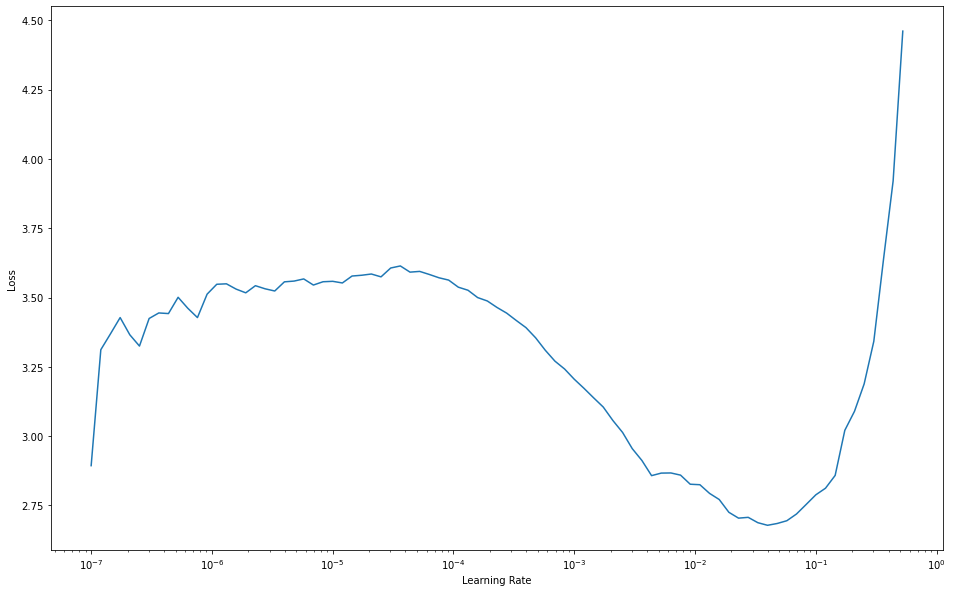

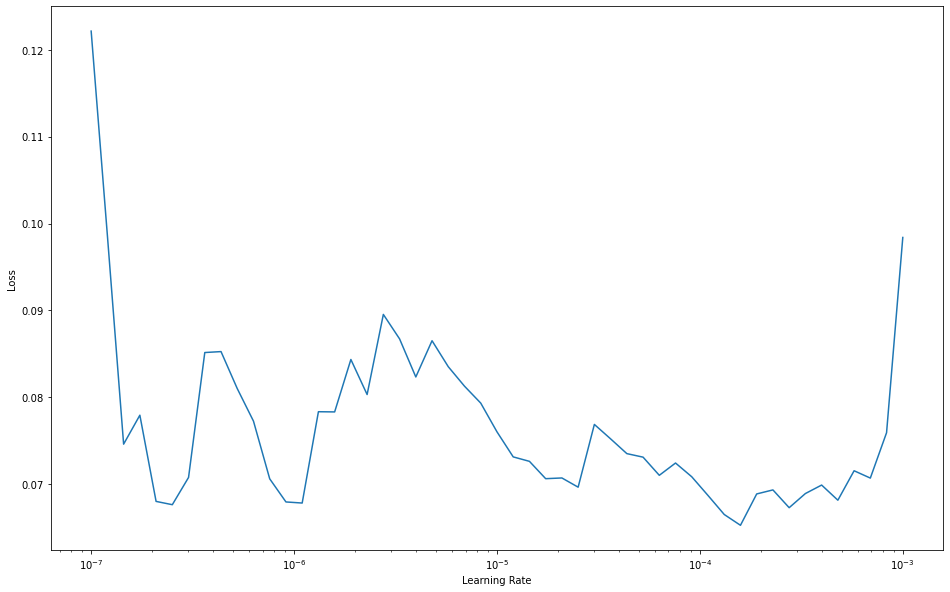

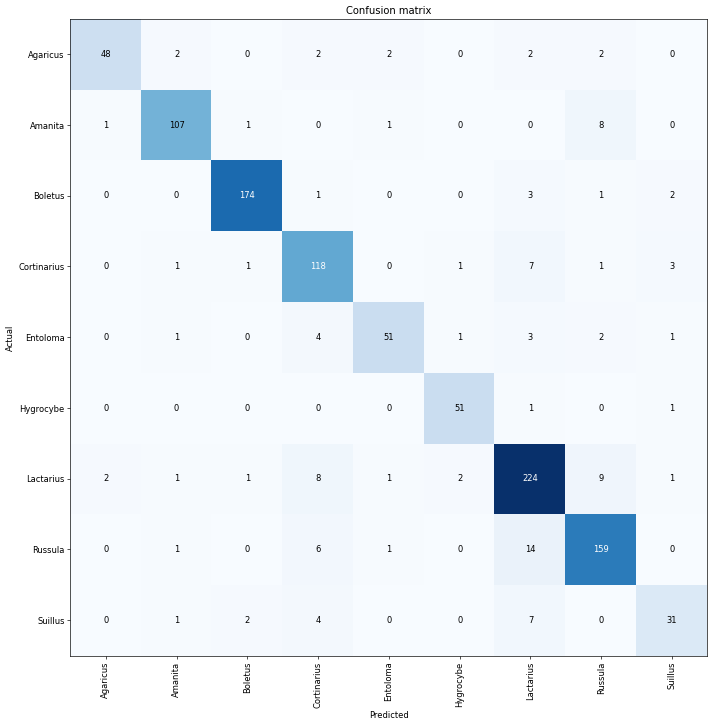

In [13]:
rn50_learner = init_model(dls, models.resnet50)
rn50_learner = train(rn50_learner)

In [14]:
rn50_learner.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 32 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    36,864     True      
_________________________________________________

# ResNet101

epoch,train_loss,valid_loss,error_rate,time
0,1.535689,1.063826,0.295370,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.798088,0.590336,0.197222,00:45
1,0.532707,0.584188,0.175926,00:48
2,0.227000,0.361460,0.115741,00:46
3,0.096056,0.334361,0.114815,00:47


(#6) [3,0.09605591744184494,0.33436086773872375,0.11481481790542603,'00:47','00:47']


epoch,train_loss,valid_loss,error_rate,time
0,0.100587,0.460166,0.122222,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.212952,0.867017,0.200000,00:45
1,0.290109,0.573981,0.151852,00:43
2,0.130511,0.425228,0.112963,00:44
3,0.056110,0.417565,0.115741,00:46


(#6) [3,0.05610959604382515,0.4175650477409363,0.11574073880910873,'00:46','00:46']


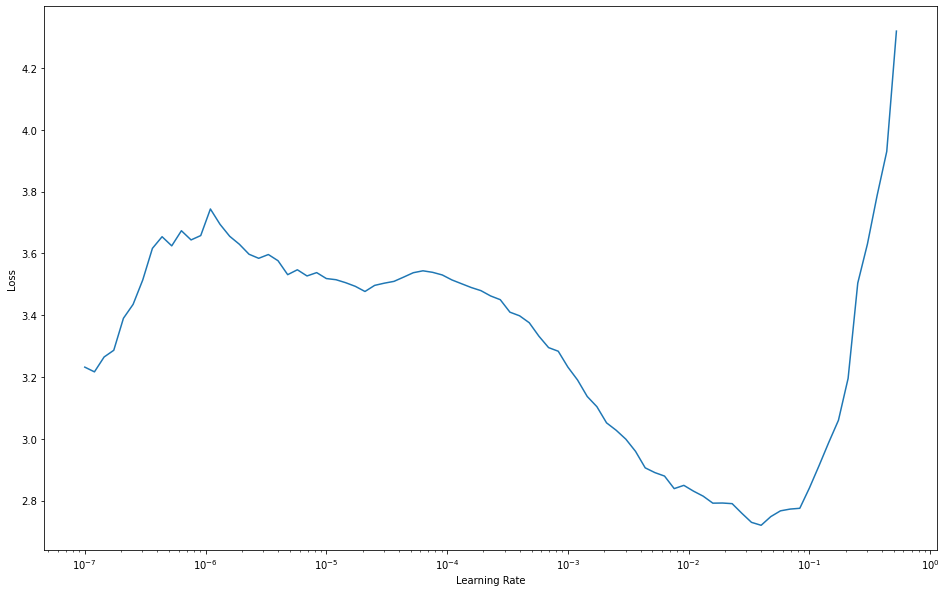

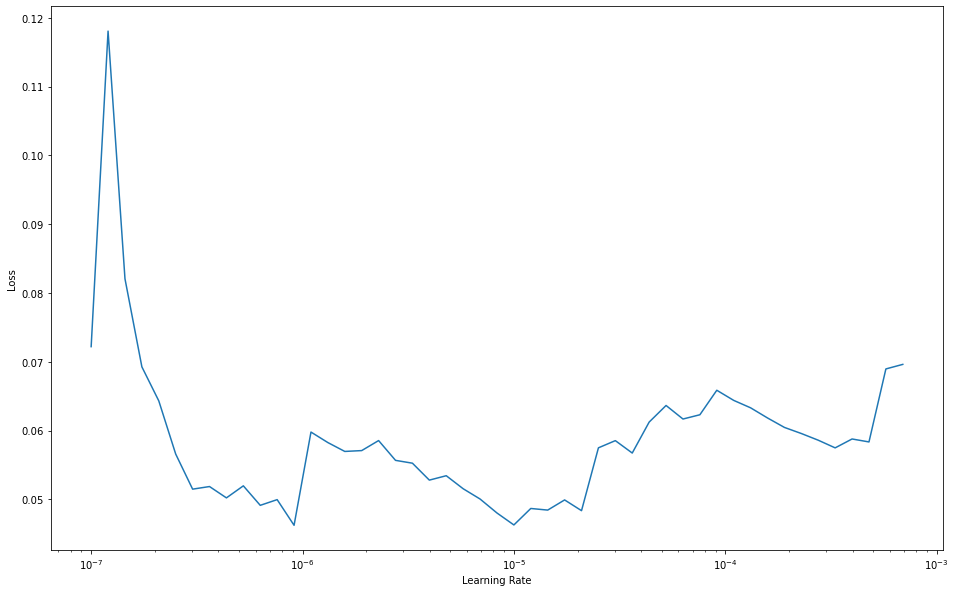

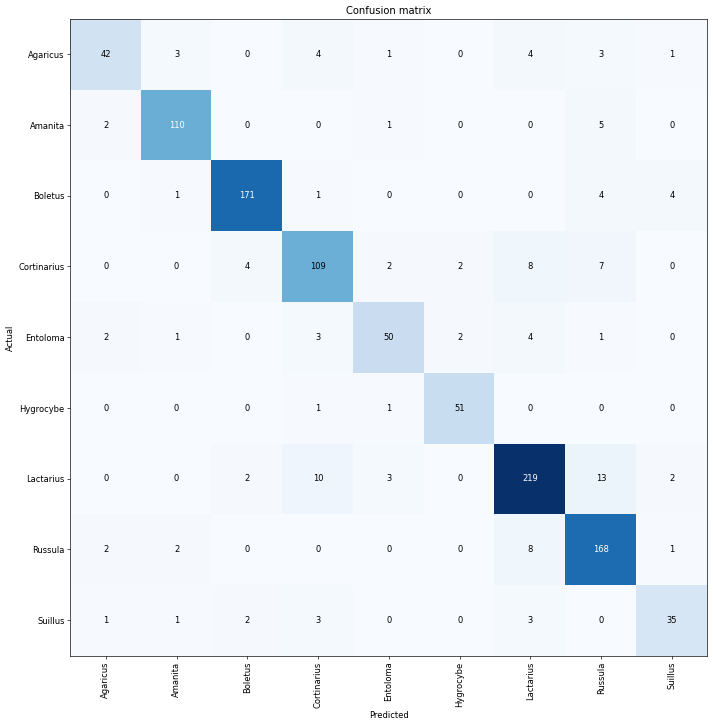

In [15]:
rn101_learner = init_model(dls, models.resnet101)
rn101_learner = train(rn101_learner)

In [16]:
rn101_learner.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 112 x 112  9,408      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 32 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    4,096      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 56 x 56    128        True      
________________________________________________________________
Conv2d               32 x 64 x 56 x 56    36,864     True      
_________________________________________________

# Alexnet

epoch,train_loss,valid_loss,error_rate,time
0,2.025070,1.163337,0.376852,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.414825,0.923308,0.337037,00:13
1,1.131055,0.840983,0.276852,00:13
2,0.873096,0.750000,0.247222,00:12
3,0.730557,0.735957,0.242593,00:13


(#6) [3,0.7305569648742676,0.735957145690918,0.24259258806705475,'00:13','00:13']


epoch,train_loss,valid_loss,error_rate,time
0,0.719684,0.790075,0.262037,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.707861,0.743298,0.241667,00:12
1,0.694777,0.737935,0.231481,00:12
2,0.485176,0.664017,0.207407,00:12
3,0.385720,0.667363,0.217593,00:12


(#6) [3,0.385720431804657,0.6673631072044373,0.21759259700775146,'00:12','00:12']


epoch,train_loss,valid_loss,error_rate,time
0,0.403290,0.748699,0.227778,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.424496,0.782425,0.238889,00:12
1,0.402383,0.741009,0.233333,00:12
2,0.300154,0.744841,0.224074,00:12
3,0.240593,0.717327,0.215741,00:12


(#6) [3,0.24059335887432098,0.7173274755477905,0.21574074029922485,'00:12','00:12']


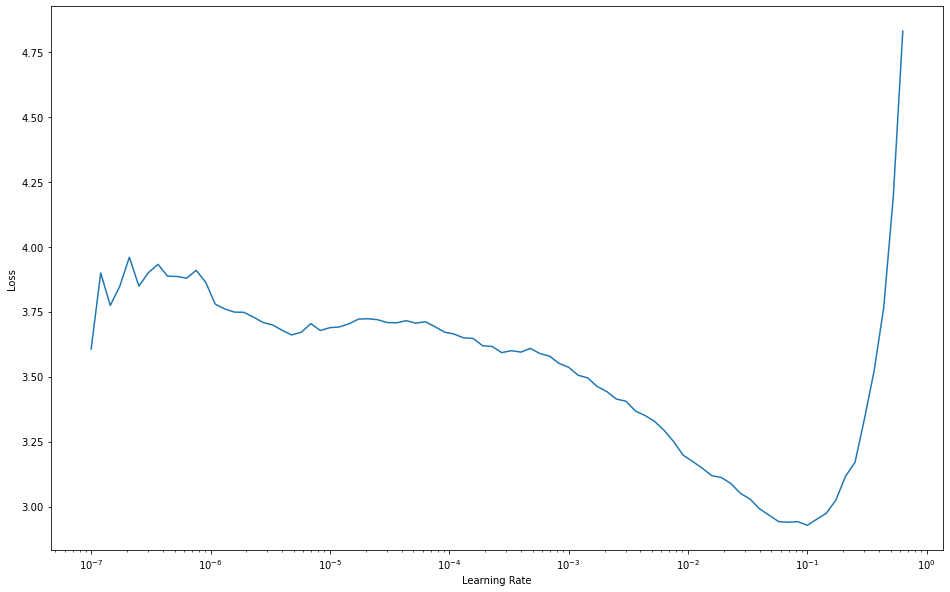

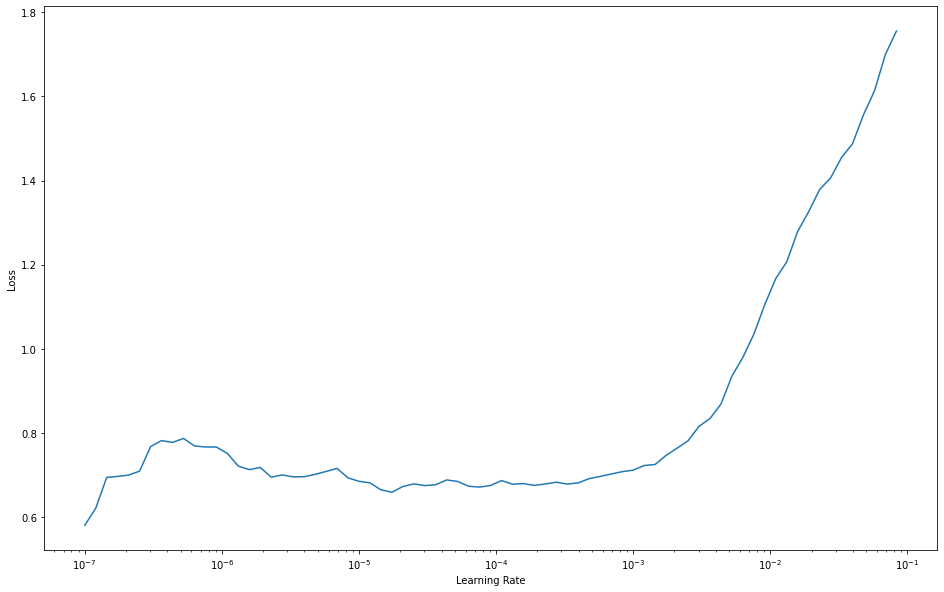

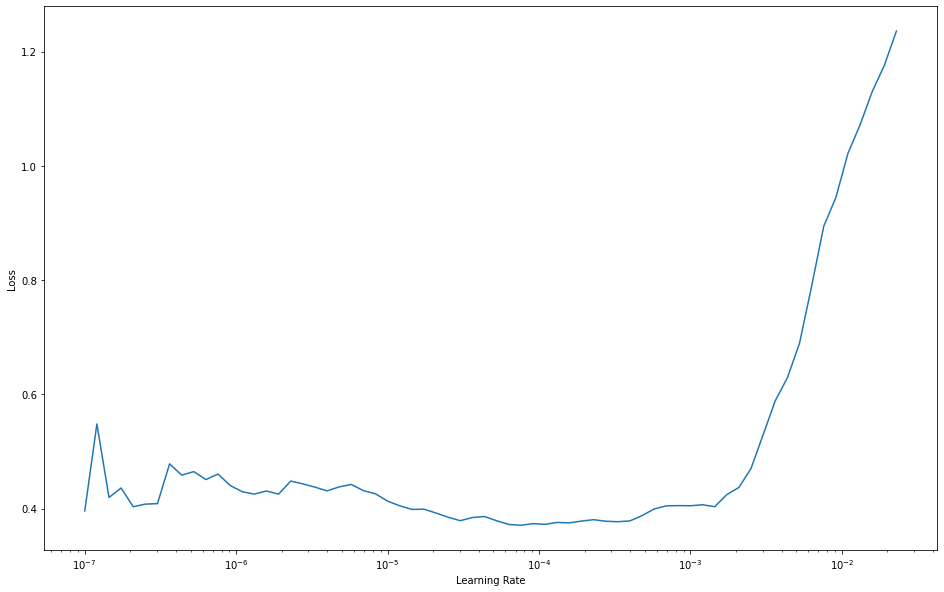

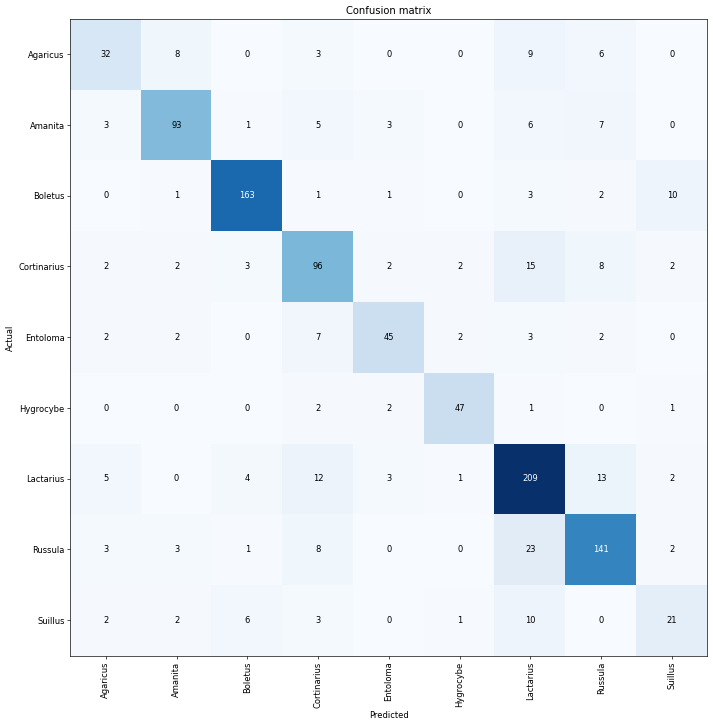

In [17]:
alexnet_learner = init_model(dls, models.alexnet)
alexnet_learner = train(alexnet_learner)

In [18]:
alexnet_learner.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 55 x 55    23,296     True      
________________________________________________________________
ReLU                 32 x 64 x 55 x 55    0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 27 x 27    0          False     
________________________________________________________________
Conv2d               32 x 192 x 27 x 27   307,392    True      
________________________________________________________________
ReLU                 32 x 192 x 27 x 27   0          False     
________________________________________________________________
MaxPool2d            32 x 192 x 13 x 13   0          False     
________________________________________________________________
Conv2d               32 x 384 x 13 x 13   663,936    True      
_________________________________________________

# VGG16

epoch,train_loss,valid_loss,error_rate,time
0,1.725652,1.017042,0.310185,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.897682,0.626018,0.201852,00:44
1,0.562101,0.469301,0.152778,00:45
2,0.252608,0.396904,0.132407,00:44
3,0.129049,0.374527,0.123148,00:44


(#6) [3,0.12904949486255646,0.3745269775390625,0.12314815074205399,'00:44','00:44']


epoch,train_loss,valid_loss,error_rate,time
0,0.143317,0.488834,0.147222,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.146087,0.560816,0.148148,00:45
1,0.214007,0.520939,0.147222,00:44
2,0.101364,0.438832,0.126852,00:45
3,0.048792,0.419364,0.122222,00:45


(#6) [3,0.04879238083958626,0.41936445236206055,0.12222222238779068,'00:45','00:45']


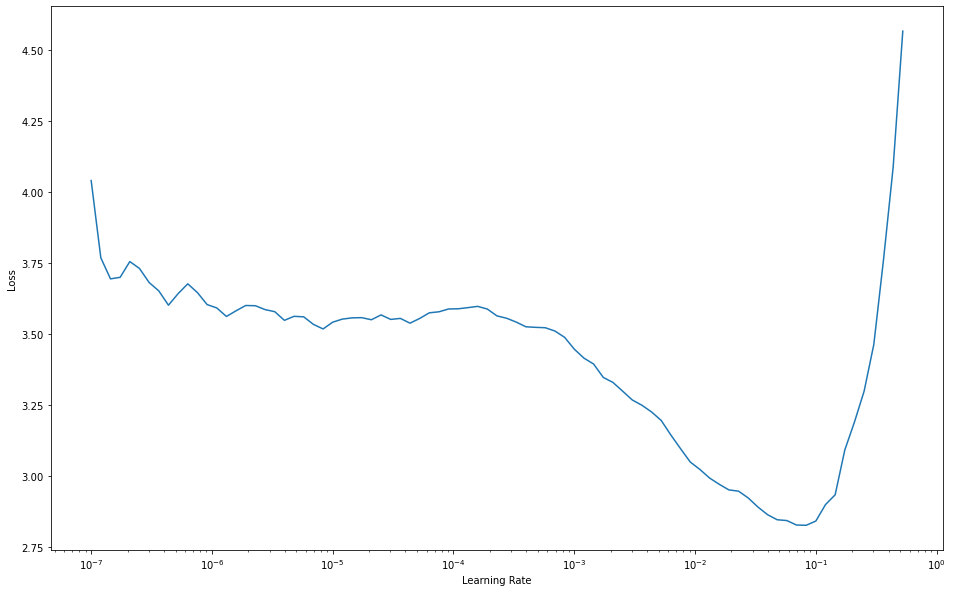

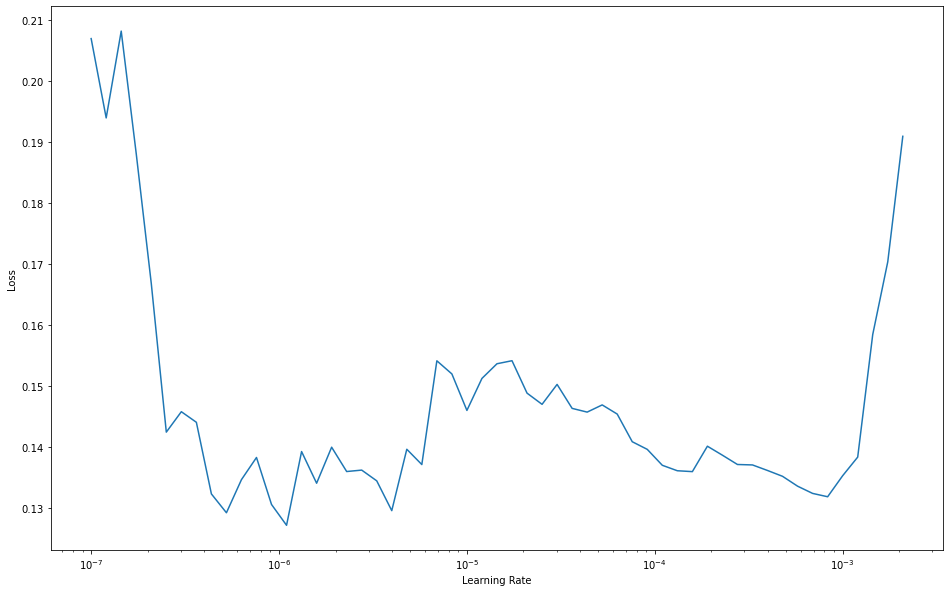

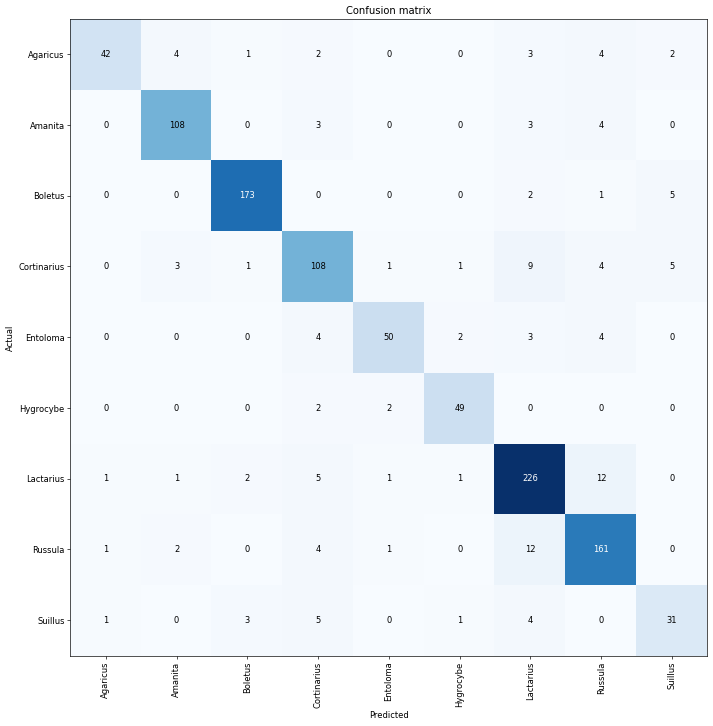

In [19]:
vgg16_learner = init_model(dls, models.vgg16_bn)
vgg16_learner = train(vgg16_learner)

In [20]:
vgg16_learner.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 224 x 224  1,792      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 32 x 64 x 224 x 224  0          False     
________________________________________________________________
Conv2d               32 x 64 x 224 x 224  36,928     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 32 x 64 x 224 x 224  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 112 x 112  0          False     
_________________________________________________

# VGG19

epoch,train_loss,valid_loss,error_rate,time
0,1.742960,0.976836,0.320370,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.968306,0.595092,0.197222,00:54
1,0.541292,0.461684,0.150926,00:53
2,0.249998,0.393284,0.125926,00:51
3,0.130609,0.384481,0.125000,00:50


(#6) [3,0.13060864806175232,0.38448095321655273,0.125,'00:50','00:50']


epoch,train_loss,valid_loss,error_rate,time
0,0.100610,0.461398,0.133333,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.148083,0.683701,0.177778,00:50
1,0.256934,0.570909,0.153704,00:50
2,0.107924,0.462594,0.122222,00:50
3,0.056173,0.433247,0.117593,00:50


(#6) [3,0.05617251619696617,0.4332473874092102,0.11759259551763535,'00:50','00:50']


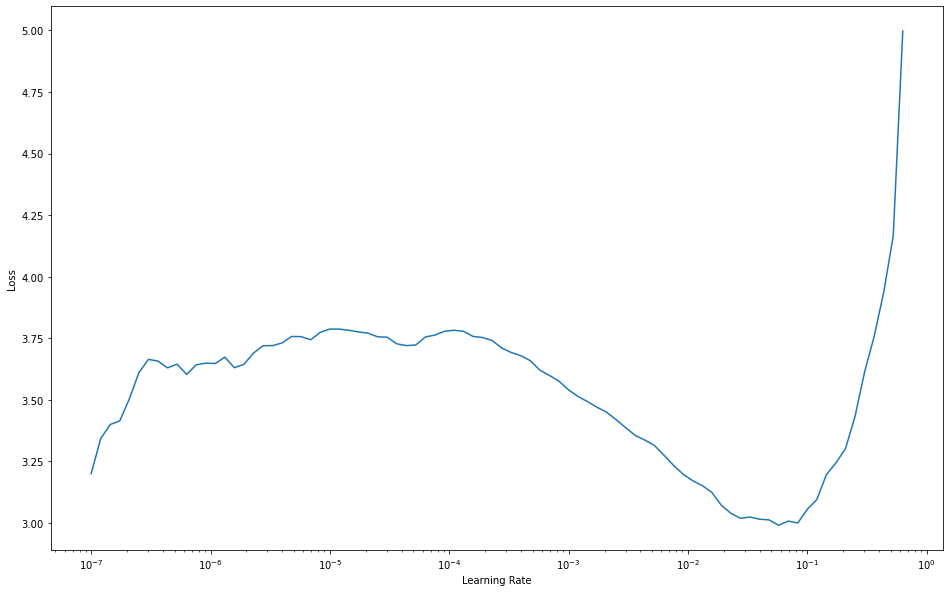

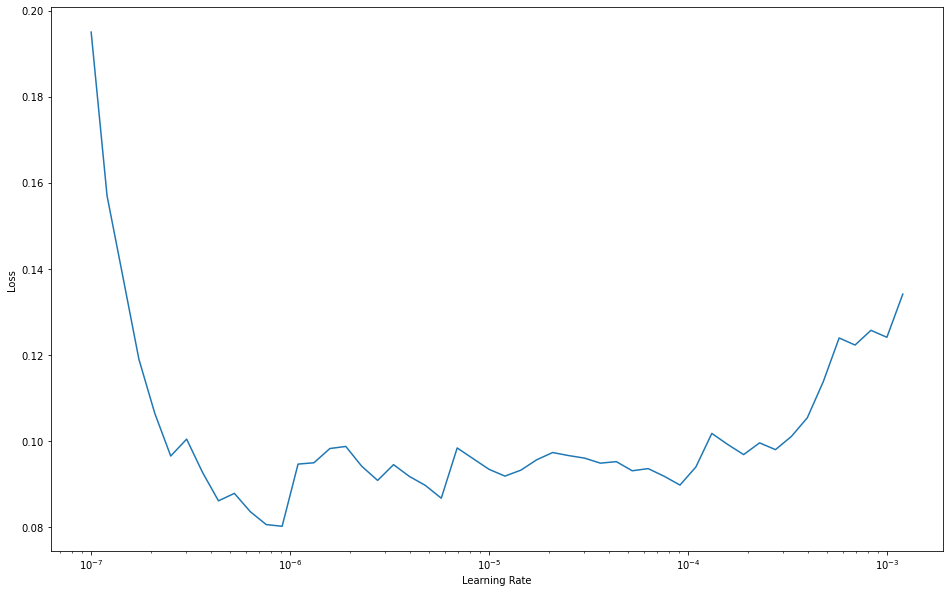

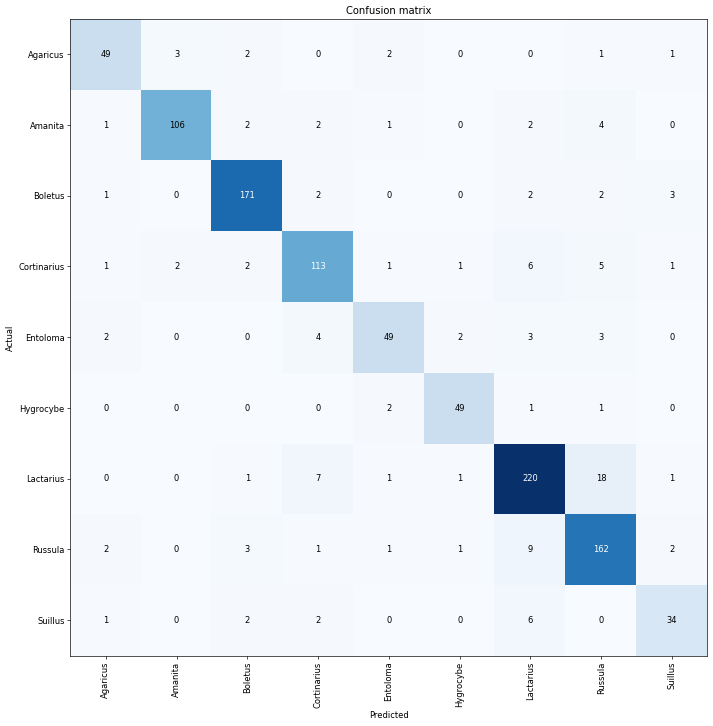

In [21]:
vgg19_learner = init_model(dls, models.vgg19_bn)
vgg19_learner = train(vgg19_learner)

In [22]:
vgg19_learner.summary()

Sequential (Input shape: ['32 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 224 x 224  1,792      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 32 x 64 x 224 x 224  0          False     
________________________________________________________________
Conv2d               32 x 64 x 224 x 224  36,928     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 224 x 224  128        True      
________________________________________________________________
ReLU                 32 x 64 x 224 x 224  0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 112 x 112  0          False     
_________________________________________________

# Comparison

In [23]:
accuracies = []
CNNs = ["ResNet50", "ResNet101", "Alexnet", "VGG16", "VGG19"]

accuracies.append(accuracy(*rn50_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*rn101_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*alexnet_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*vgg16_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*vgg19_learner.get_preds(dl=test_dls)).item())

ResNet50 test accuracy: 0.8765243887901306
ResNet101 test accuracy: 0.894817054271698
Alexnet test accuracy: 0.7705792784690857
VGG16 test accuracy: 0.8757622241973877
VGG19 test accuracy: 0.8765243887901306


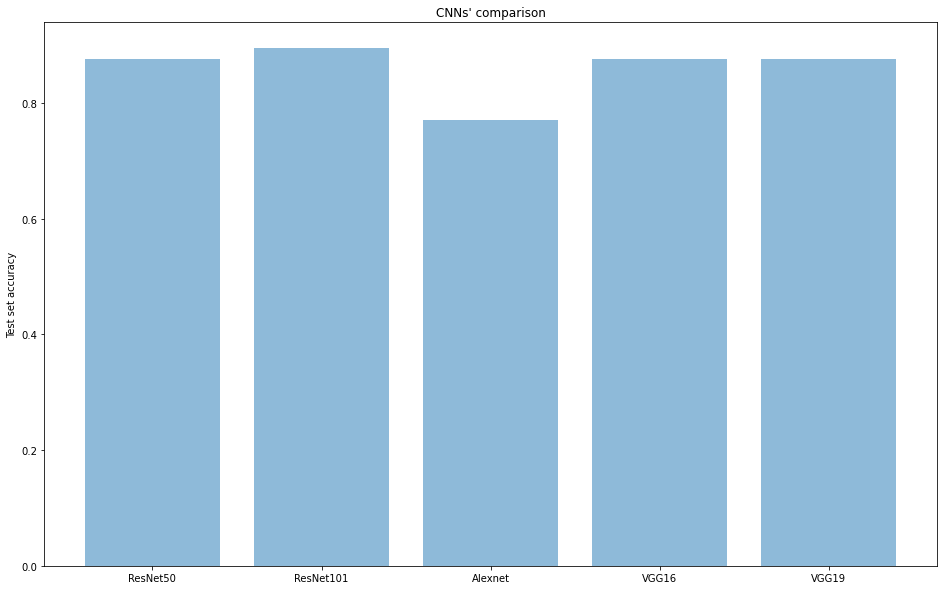

In [24]:
y_pos = np.arange(len(CNNs))
for i in range(len(accuracies)):
  print("{} test accuracy: {}".format(CNNs[i], accuracies[i]))

plt.bar(y_pos, accuracies, align='center', alpha=0.5)
plt.xticks(y_pos, CNNs)
plt.ylabel('Test set accuracy')
plt.title("CNNs' comparison")

plt.show()